In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd data

C:\Users\Mohamad\Documents\GitHub\MedCampHackathon\data


# Pull in data sources
## Test Data

In [3]:
def loadTestData():
    test_data = pd.read_csv('Test.csv',sep=',', parse_dates=[2], index_col=['Patient_ID', 'Health_Camp_ID'])
    return test_data

## Training Data

In [4]:
def loadTrainData():
    train_data = pd.read_csv('Train/Train.csv',sep=',', parse_dates=[2], index_col=['Patient_ID', 'Health_Camp_ID'])
    return train_data

## Merge in some other key fields
### Define a function that will merge in all other fields into dataset

In [5]:
def getData(sourceData):
    HC1 = pd.read_csv('Train/First_Health_Camp_Attended.csv', sep=',', index_col=['Patient_ID', 'Health_Camp_ID'])
    HC1.pop('Unnamed: 4')
    sourceData['Health_Camp_Score_1'] = HC1['Health_Score']
    sourceData['Health_Camp_Attended_1'] = sourceData['Health_Camp_Score_1'].apply(lambda x: True if x > 0 else False)

    HC2 = pd.read_csv('Train/Second_Health_Camp_Attended.csv', sep=',', index_col=['Patient_ID','Health_Camp_ID'])
    sourceData['Health_Camp_Score_2'] = HC2['Health Score']
    sourceData['Health_Camp_Attended_2'] = sourceData['Health_Camp_Score_2'].apply(lambda x: True if x > 0 else False)

    HC3 = pd.read_csv('Train/Third_Health_Camp_Attended.csv', sep=',', index_col=['Patient_ID','Health_Camp_ID'])
    sourceData['Health_Camp_Stalls_3'] = HC3['Number_of_stall_visited']
    sourceData['Health_Camp_Attended_3'] = sourceData['Health_Camp_Stalls_3'].apply(lambda x: True if x > 0 else False)

    ### Positive_Result

    sourceData['Positive_Result'] = (sourceData['Health_Camp_Attended_1'] | sourceData['Health_Camp_Attended_2'] | sourceData['Health_Camp_Attended_3'])

    ### Health_Camp_Details

    HCDetails = pd.read_csv('Train/Health_Camp_Detail.csv', sep=',', index_col='Health_Camp_ID', parse_dates=[1,2])
    sourceData = sourceData.join(HCDetails)

    ### Patient Details

    PatientProfiles = pd.read_csv('Train/Patient_Profile.csv', sep=',', index_col='Patient_ID', parse_dates=[8])
    sourceData = sourceData.join(PatientProfiles)

    ### Add in the reg_num

    df = sourceData[['Registration_Date','Positive_Result']]
    df.reset_index(level=['Patient_ID','Health_Camp_ID'], inplace=1)
    hist = df.sort_values(by=['Patient_ID','Registration_Date'])
    hist.set_index(['Patient_ID','Health_Camp_ID'], inplace=1)

    sourceData['reg_num'] = hist.groupby(level=0).cumcount()
    
    ### Repeat Register Flag
    sourceData['rep_reg'] = sourceData['reg_num'].apply(lambda x: True if x > 0 else False)
    
    ### rep_reg_bin

    # define a bin size
    size = 8
    bins = np.logspace(np.log2(0.99), np.log2(sourceData.reg_num.max()), size, endpoint=True, base=2)

    sourceData['rep_reg_bin'] = pd.cut(sourceData.reg_num, bins).cat.rename_categories([1,2,3,4,5,6,7])
    sourceData['rep_reg_bin'] = sourceData['rep_reg_bin'].cat.add_categories(-1)
    sourceData['rep_reg_bin'] = sourceData['rep_reg_bin'].fillna(-1)
    
    #train_data['rep_reg_bin'] = train_data['rep_reg_bin'].cat.rename_categories([1,2,3,4,5,6,7])
    
    ### has_var
    sourceData['has_var'] = (sourceData['Var1'] > 0) | (sourceData['Var2'] > 0) | (sourceData['Var3'] > 0) | (sourceData['Var4'] > 0) | (sourceData['Var5'] > 0) 
    
    ### v1_b
    # define a bin size
    #size = 5
    #bins = np.logspace(np.log2(.99), np.log2(sourceData.Var1.max()), size, endpoint=True, base=2)

    #sourceData['v1_b'] = pd.cut(sourceData.Var1, bins).cat.rename_categories([1,2,3,4])
    #sourceData['v1_b'] = sourceData['v1_b'].cat.add_categories(-1)
    #sourceData['v1_b'] = sourceData['v1_b'].fillna(-1)
    
    ### online   
    sourceData['online'] = (sourceData['Online_Follower']) | (sourceData['LinkedIn_Shared']) | (sourceData['Twitter_Shared']) | (sourceData['Facebook_Shared'])
    
    ### City_Type
    sourceData['City_Type'] = sourceData['City_Type'].fillna('Z')
    
    ### Age
    val_counts = sourceData['Age'].value_counts().to_dict()
    #mode_age = sourceData['Age'].mode()
    for key, value in val_counts.items():
        if key == 'None':
            val_counts[key] = None
        else:
            val_counts[key] = int(key)
    val_counts
    sourceData['Age'] = sourceData['Age'].apply(lambda x: val_counts.get(x))
    sourceData['Age'] = sourceData['Age'].fillna(41)
    
    ### Education_Score
    val_counts = sourceData['Education_Score'].value_counts().to_dict()
    for key, value in val_counts.items():
        if key == 'None':
            val_counts[key] = None
        else:
            val_counts[key] = float(key)
    val_counts
    sourceData['Education_Score'] = sourceData['Education_Score'].apply(lambda x: val_counts.get(x))
    
    ### Employer_Category
    sourceData['Employer_Category'] = sourceData['Employer_Category'].fillna('None Provided')
    
    ### Time Since First Interaction
    sourceData['DaysSeen'] = sourceData.Registration_Date - sourceData.First_Interaction

    ### DaysSeen
    sourceData.DaysSeen = sourceData[sourceData.DaysSeen.notnull()].DaysSeen.apply(lambda x: x.days)
    sourceData.DaysSeen = sourceData.DaysSeen.fillna(0)

    
    return sourceData

In [6]:
train_data = getData(loadTrainData())

In [7]:
### var1-5 train_data
vars = ['Var3','Var4','Var5','Var1','Var2','Age','reg_num','DaysSeen']
scaler = {}


# bin data and store scale to apply to test_data
### v1_b
# define a bin size
size = 5
scaler['v1_b'] = np.logspace(np.log2(.99), np.log2(train_data.Var1.max()), size, endpoint=True, base=2)
train_data['v1_b'] = pd.cut(train_data.Var1, scaler['v1_b']).cat.rename_categories([1,2,3,4])
train_data['v1_b'] = train_data['v1_b'].cat.add_categories(-1)
train_data['v1_b'] = train_data['v1_b'].fillna(-1)

### v2_b
# define a bin size
size = 5
scaler['v2_b'] = np.logspace(np.log2(.99), np.log2(train_data.Var2.max()), size, endpoint=True, base=2)
train_data['v2_b'] = pd.cut(train_data.Var2, scaler['v2_b']).cat.rename_categories([1,2,3,4])
train_data['v2_b'] = train_data['v2_b'].cat.add_categories(-1)
train_data['v2_b'] = train_data['v2_b'].fillna(-1)

### age_b
size = 5
scaler['age_b'] = np.linspace(0,train_data.Age.max(), size, endpoint=True)

train_data['age_b'] = pd.cut(train_data.Age, scaler['age_b']).cat.rename_categories([1,2,3,4])
train_data['age_b'] = train_data['age_b'].cat.add_categories(-1)
train_data['age_b'] = train_data['age_b'].fillna(-1)

### educ_b
size = 5
scaler['educ_b'] = np.linspace(0,train_data.Education_Score.max(), size, endpoint=True)

train_data['educ_b'] = pd.cut(train_data.Age, scaler['educ_b']).cat.rename_categories([1,2,3,4])
train_data['educ_b'] = train_data['educ_b'].cat.add_categories(-1)
train_data['educ_b'] = train_data['educ_b'].fillna(-1)
    
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()


for var in vars:
    scaler[var] = scale.fit(train_data[var])
    #x_minmax = scale.fit(train_data[var])
    #print(x_minmax)
    
    train_data[var] = scaler[var].transform(train_data[var])

D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Conda\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Conda\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature 

In [8]:
test_data = getData(loadTestData())
drops = ['Health_Camp_Score_1','Health_Camp_Attended_1','Health_Camp_Score_2','Health_Camp_Attended_2','Health_Camp_Stalls_3','Health_Camp_Attended_3','Positive_Result']
for col in drops:
    test_data.pop(col)

In [9]:
### var1-5 test_data

test_data['v1_b'] = pd.cut(test_data.Var1, scaler['v1_b']).cat.rename_categories([1,2,3,4])
test_data['v1_b'] = test_data['v1_b'].cat.add_categories(-1)
test_data['v1_b'] = test_data['v1_b'].fillna(-1)

test_data['v2_b'] = pd.cut(test_data.Var2, scaler['v2_b']).cat.rename_categories([1,2,3,4])
test_data['v2_b'] = test_data['v2_b'].cat.add_categories(-1)
test_data['v2_b'] = test_data['v2_b'].fillna(-1)

test_data['age_b'] = pd.cut(test_data.Age, scaler['age_b']).cat.rename_categories([1,2,3,4])
test_data['age_b'] = test_data['age_b'].cat.add_categories(-1)
test_data['age_b'] = test_data['age_b'].fillna(-1)

test_data['educ_b'] = pd.cut(test_data.Age, scaler['educ_b']).cat.rename_categories([1,2,3,4])
test_data['educ_b'] = test_data['educ_b'].cat.add_categories(-1)
test_data['educ_b'] = test_data['educ_b'].fillna(-1)

for var in vars:
    test_data[var] = scaler[var].transform(test_data[var].reshape(-1,1)).reshape(1,-1)[0]


D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Conda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Co

# Bring in main model function

In [10]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    #Fit the model
    model.fit(data[predictors],data[outcome])
    
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
  
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print ("Accuracy : %s" % "{0:.3%}".format(accuracy))
    
    # Record auc score
    auc = metrics.roc_auc_score(data[outcome], predictions)
    
    print ("ROC AUC Score : %s" % "{0:.3%}".format(auc))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])
    
        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]
    
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome])
    
    # return the roc_auc score to be stored
    return model
    
    


### Encode the data for sklearn

In [11]:
from sklearn.preprocessing import LabelEncoder
var_mod = ['Category1','Category2','Category3','rep_reg_bin','City_Type','age_b','educ_b','v1_b','v2_b','Employer_Category']
le = LabelEncoder()
for i in var_mod:
    train_data[i] = le.fit_transform(train_data[i])
    #scaler[i] = scale.fit(train_data[i])
    #train_data[i] = scaler[i].transform(train_data[i])
#train_data.dtypes




In [12]:
for i in var_mod:
    test_data[i] = le.fit_transform(test_data[i])
    #test_data[i] = scaler[i].transform(test_data[i])

In [13]:
train_data.head()

,,Registration_Date,Var1,Var2,Var3,Var4,Var5,Health_Camp_Score_1,Health_Camp_Attended_1,Health_Camp_Score_2,Health_Camp_Attended_2,...,reg_num,rep_reg,rep_reg_bin,has_var,online,DaysSeen,v1_b,v2_b,age_b,educ_b
Patient_ID,Health_Camp_ID,,,,,,,,,,,,,,,,,,,,,
489652,6578,2005-09-10,0.420086,-0.063285,-0.019631,-0.11236,1.442928,NaN,False,NaN,False,...,1.695679,True,5,True,0,0.302927,1,0,1,0
507246,6578,2005-08-18,5.795981,1.263127,-0.019631,-0.11236,5.561781,NaN,False,NaN,False,...,2.592913,True,5,True,0,0.546566,3,2,0,0
523729,6534,2006-04-29,-0.104391,-0.063285,-0.019631,-0.11236,-0.204613,NaN,False,0.402054,True,...,0.499368,True,3,False,0,1.772144,0,0,1,0
524931,6535,2004-02-07,-0.104391,-0.063285,-0.019631,-0.11236,-0.204613,NaN,False,NaN,False,...,-0.696944,False,0,False,0,-0.723311,0,0,1,0
521364,6529,2006-02-28,1.862400,0.201998,-0.019631,-0.11236,5.561781,NaN,False,0.845597,True,...,4.088302,True,6,True,1,2.857445,2,1,0,0


In [14]:
test_data.head()

,,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,Category1,Category2,...,reg_num,rep_reg,rep_reg_bin,has_var,online,DaysSeen,v1_b,v2_b,age_b,educ_b
Patient_ID,Health_Camp_ID,,,,,,,,,,,,,,,,,,,,,
505701,6548,2006-05-21,-0.719619,-0.723311,-0.723311,-0.723311,-0.715928,2006-06-13,2006-08-18,2,5,...,-0.715928,True,2,True,0,3.710182,1,0,1,0
500633,6584,2006-06-02,-0.723311,-0.723311,-0.723311,-0.723311,-0.723311,2006-08-04,2006-08-09,1,0,...,-0.719619,True,1,False,1,1.262717,0,0,1,0
506945,6582,2006-08-10,-0.723311,-0.723311,-0.723311,-0.723311,-0.723311,2006-04-06,2007-11-07,0,4,...,-0.712236,True,3,False,0,-0.306171,0,0,1,0
497447,6551,2006-08-27,-0.723311,-0.723311,-0.723311,-0.723311,-0.723311,2006-11-13,2006-11-18,1,2,...,-0.719619,True,1,False,0,-0.715928,0,0,1,0
496446,6533,2006-09-19,-0.723311,-0.723311,-0.723311,-0.723311,-0.723311,2006-09-20,2006-09-23,0,3,...,-0.723311,False,0,False,0,-0.723311,0,0,1,0


## Pick the model that we want to use and fit the model

In [15]:
# I want to write a loop to test out a couple of different models and show the results
# I need a variable to hold the scenarios to run - it will be a list of dicts describing each run
outcome_var = 'Positive_Result'
predictor_var1 = ['Category1','Category2','Category3','rep_reg_bin','City_Type','age_b','educ_b','online','v1_b','v2_b','Employer_Category']
predictor_var2 = ['Category1','Category2','rep_reg_bin','City_Type','age_b','educ_b','online','v1_b','v2_b','has_var','Employer_Category']
predictor_var3 = ['DaysSeen','Category1','Category2','Category3','reg_num','rep_reg','City_Type','Age','educ_b','online','has_var','Employer_Category']
predictor_var4 = ['DaysSeen','Category1','Category2','Category3','rep_reg','reg_num','City_Type','Age','educ_b','online','Var1','Var2','Var3','Var4','Var5','Employer_Category']
predictor_var5 = ['Category1','Category2','Category3','rep_reg','reg_num','City_Type','Age','educ_b','online','Var1','Var2','Var3','Var4','Var5','has_var','Employer_Category']
predictor_var6 = ['DaysSeen','Category1','Category2','Category3','rep_reg','reg_num','City_Type','Age','educ_b','online','Var1','Var2','Var3','Var4','Var5','has_var','Employer_Category']
scenarios = []
scores = []

# define scenarios I want to run

### LinearSVC
# Setup paramaters to search for this scenario
c_values = list(np.logspace(np.log2(0.0001),np.log2(.05),25, base=2))
penalty = ['l2']
loss = ['squared_hinge']
param_grid = dict(C=c_values, penalty=penalty, loss=loss)
#scenarios.append(dict(model=LinearSVC(tol=.000001, max_iter=1500, dual=False), predictors=predictor_var1, params=param_grid))
#scenarios.append(dict(model=LinearSVC(tol=.000001, max_iter=1500, dual=False), predictors=predictor_var2, params=param_grid))
#scenarios.append(dict(model=LinearSVC(tol=.000001, max_iter=1500, dual=False), predictors=predictor_var3, params=param_grid))
#scenarios.append(dict(model=LinearSVC(tol=.000001, max_iter=1500, dual=False), predictors=predictor_var4, params=param_grid))
#scenarios.append(dict(model=LinearSVC(tol=.000001, max_iter=1500, dual=False), predictors=predictor_var5, params=param_grid))
scenarios.append(dict(model=LinearSVC(tol=.000001, max_iter=1500, dual=False), predictors=predictor_var6, params=param_grid))

### RBF SVC
c_values = list(np.logspace(np.log2(0.01),np.log2(10),10, base=2))
kernel= ['linear','poly','rbf','sigmoid']
param_grid = dict(C=c_values)
#scenarios.append(dict(model=SVC(), predictors=predictor_var, params=param_grid))

### LogisticRegression
# Setup paramaters to search for this scenario
c_values = list(np.logspace(np.log2(0.001),np.log2(.05),25, base=2))
solver_options = ['newton-cg','lbfgs','sag','liblinear']
param_grid = dict(C=c_values, solver=solver_options)
#scenarios.append(dict(model=LogisticRegression(), predictors=predictor_var, params=param_grid))

### DecisionTree
criterion = ['gini','entropy']
max_features = [None, 1, 2, 4, 6]
max_depth = [None, 4, 6, 8]
param_grid = dict(criterion=criterion, max_features=max_features, max_depth=max_depth)
#scenarios.append(dict(model=DecisionTreeClassifier(), predictors=predictor_var, params=param_grid))

### Random Forest
param_grid = {}
#scenarios.append(dict(model=RandomForestClassifier(n_estimators=100), predictors=predictor_var, params=param_grid))

# second run
n_estimators = [10, 20, 35, 50, 75]
max_depth = [None, 4, 8, 12]
max_features = [None, 1, 2, 4]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
predictors = ['Category1', 'Category2', 'Employer_Category', 'rep_reg_bin', 'City_Type'] #top 5 inserted from below
#scenarios.append(dict(model=RandomForestClassifier(n_estimators=25), predictors=predictors, params=param_grid))

from sklearn.grid_search import GridSearchCV

# iterate through them
for scenario in scenarios:
    #classification_model(scenario['model'], train_data, scenario['predictors'], outcome_var)
    #score = metrics.roc_auc_score(train_data[outcome_var], scenario['model'].predict(train_data[scenario['predictors']]))

    grid = GridSearchCV(scenario['model'], param_grid=scenario['params'], cv=None, scoring='roc_auc', verbose=1, n_jobs=4)
    grid.fit(train_data[scenario['predictors']],train_data.Positive_Result)
    scenario['model'] = grid.best_estimator_
    predictions = scenario['model'].predict(train_data[scenario['predictors']])
    score = metrics.roc_auc_score(train_data.Positive_Result, predictions)
    scores.append(score)

### Include a final run of 
# Grab Feature Importance Table





Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:   26.3s finished


In [16]:
# select model with the best auc score
best_scenario = scores.index(max(scores))
scenarios[best_scenario]
scores

[0.6714906172589209]

In [17]:
scenarios[best_scenario]['predictors']

['DaysSeen',
 'Category1',
 'Category2',
 'Category3',
 'rep_reg',
 'reg_num',
 'City_Type',
 'Age',
 'educ_b',
 'online',
 'Var1',
 'Var2',
 'Var3',
 'Var4',
 'Var5',
 'has_var',
 'Employer_Category']

In [18]:
# Load the parameters we want to run
#scenarios[best_scenario]['model'].set_params(**grid.best_params_)
    

# Run the model
classification_model(scenarios[best_scenario]['model'], train_data, scenarios[best_scenario]['predictors'], outcome_var)

# Save the predicted labels to the dataset
train_data['predicted'] = scenarios[best_scenario]['model'].predict(train_data[scenarios[best_scenario]['predictors']])

# Output the model used
scenarios[best_scenario]['model']

Accuracy : 76.640%
ROC AUC Score : 67.149%
Cross-Validation Score : 76.643%


LinearSVC(C=0.010573712634405636, class_weight=None, dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1500, multi_class='ovr', penalty='l2', random_state=None,
     tol=1e-06, verbose=0)

In [19]:
#Version for LinearSVC
clf = CalibratedClassifierCV(scenarios[best_scenario]['model'])
clf.fit(train_data[scenarios[best_scenario]['predictors']],train_data[outcome_var])
results = clf.predict_proba(test_data[scenarios[best_scenario]['predictors']])
formatted = list()
for pFalse,pTrue  in results:
    formatted.append(pTrue)

outcome = pd.Series(formatted, index=test_data.index)

test_data['Outcome'] = outcome
test_data['Outcome'].to_csv('output.csv', header=True)

# Look into results
## What values do we miss on the training sample?

In [20]:
# null accuracy for the problem
train_data.Positive_Result.value_counts().head(1) / len(train_data.Positive_Result)

False    0.727224
Name: Positive_Result, dtype: float64

### Confusion Matrix 

In [21]:
# confusion matrix
train_data.groupby(['predicted','Positive_Result']).size().unstack(0)

predicted,False,True
Positive_Result,,
False,48193,6551
True,11034,9500


In [22]:
confusion = metrics.confusion_matrix(train_data.Positive_Result, train_data.predicted)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

### Classification Accuracy - *How often is the classifier correct?*

In [23]:
print((TP + TN) / (FP + FN + TP + TN))
print(metrics.accuracy_score(train_data.Positive_Result, train_data.predicted))

0.766399213582
0.766399213582


### Sensitivity - *When the actual value is positive, how often is the prediction correct?*
 * How 'sensitive' or selective is the model with detecting a positive instance?

In [24]:
print((TP) / (TP + FN))
print(metrics.recall_score(train_data.Positive_Result, train_data.predicted))

0.462647316646
0.462647316646


### Specificity - *When the actual value is negative, how often is the prediction correct?*

In [25]:
(TN) / (TN + FP)

0.88033391787227822

### False Positives Rate - *When the actual value is negative, how often is the prediction incorrect?*

In [26]:
FP / (FP + TN)

0.11966608212772176

### Precision - *When a positive value is predicted, how often is the prediction correct?*
 * How precise the classifier is when selecting a positive instance?

In [27]:
print(TP / (TP + FP))
print(metrics.precision_score(train_data.Positive_Result, train_data.predicted))

0.5918634353
0.5918634353


In [28]:
print(metrics.classification_report(train_data['Positive_Result'], train_data['predicted'], target_names=['False', 'True']))

             precision    recall  f1-score   support

      False       0.81      0.88      0.85     54744
       True       0.59      0.46      0.52     20534

avg / total       0.75      0.77      0.76     75278



In [30]:
results = clf.predict_proba(train_data[scenarios[best_scenario]['predictors']])
formatted = list()
for pFalse,pTrue  in results:
    formatted.append(pTrue)

outcome = pd.Series(formatted, index=train_data.index)

train_data['Outcome'] = outcome

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(train_data.Positive_Result, outcome)
roc_auc = metrics.auc(fpr, tpr)

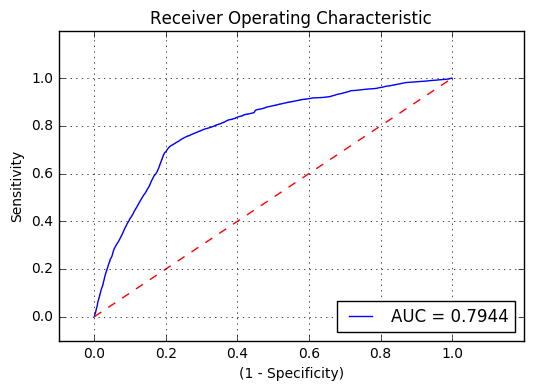

In [32]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('Sensitivity')
plt.xlabel('(1 - Specificity)')
plt.grid(True)
plt.show()